In [ ]:
#模型选择
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 数据预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),# 随机裁剪
    transforms.RandomHorizontalFlip(),# 随机水平翻转
    transforms.ToTensor(),# 将图像转换为Tensor，同时将像素值从[0, 255]范围缩放到[0.0, 1.0]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #这些值是通过计算CIFAR-10训练集中所有图像的均值和标准差得出的：
    #均值：(0.4914, 0.4822, 0.4465) - 分别对应RGB三个通道
#标准差：(0.2023, 0.1994, 0.2010) - 分别对应RGB三个通道
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载CIFAR-10数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# CIFAR-10的类别
classes = ('飞机', '汽车', '鸟', '猫', '鹿', '狗', '青蛙', '马', '船', '卡车')
# CIFAR-10的类别 (英文)
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/home/ma-user/anaconda3/envs/PyTorch-1.8.2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cuda:0
Files already downloaded and verified
Files already downloaded and verified


## VGGNet网络结构图

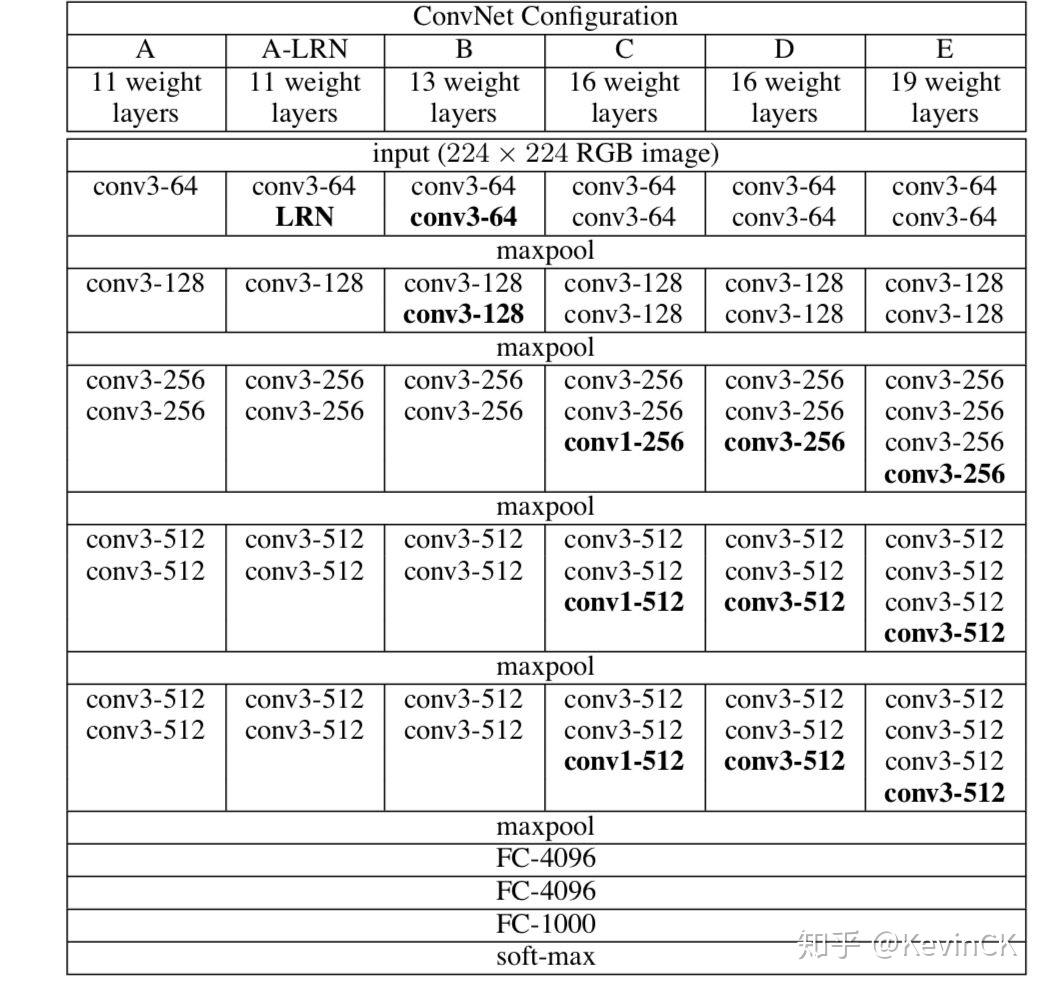

VGG耗费很多计算资源，并且使用了更多的参数（这里不是3x3卷积的锅），导致更多的内存占用。其中绝大多数的参数都是来自于第一个全连接层。

VGG本来用于1000个分类，现在只有10个分类，因此降低全连接层参数



In [2]:

# 定义VGG网络配置（不同深度）
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

# 定义VGG网络类
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        self._initialize_weights()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# 训练模型函数
def train_model(model, epochs=10, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model = model.to(device)
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    times = []
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        print(f'\n第 {epoch} 轮')
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        loop = tqdm(enumerate(trainloader), total=len(trainloader), desc=f'Training:Epoch [{epoch}/{epochs}]')
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loop.set_postfix(loss = loss.item(),acc = correct/total)

        # 计算训练结果
        train_epoch_loss = train_loss / len(trainloader)
        train_epoch_acc = 100. * correct / total
        train_losses.append(train_epoch_loss)
        train_accs.append(train_epoch_acc)
        
        # 测试
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(testloader),total=len(testloader), desc=f'Testing:'):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # 计算测试结果
        test_epoch_loss = test_loss / len(testloader)
        test_epoch_acc = 100. * correct / total
        test_losses.append(test_epoch_loss)
        test_accs.append(test_epoch_acc)
        
        epoch_time = time.time() - start_time
        times.append(epoch_time)
        
        print(f'测试 | 损失: {test_epoch_loss:.3f} | 准确率: {test_epoch_acc:.3f}% | 用时: {epoch_time:.1f}秒')
        scheduler.step()
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'times': times,
        'final_accuracy': test_accs[-1],
        'total_time': sum(times)
    }


In [3]:
# 定义要比较的VGG模型
models_to_compare = ['VGG11', 'VGG13', 'VGG16', 'VGG19']
epoch_count = 30  # 为了演示，使用较少的轮数

# 存储每个模型的结果
results = {}

# 训练和评估每个模型
for model_name in models_to_compare:
    print(f"\n开始训练 {model_name} 模型...")
    model = VGG(model_name)
    results[model_name] = train_model(model, epochs=epoch_count)
    # 保存模型
    torch.save(model.state_dict(), f'cifar10_{model_name.lower()}.pth')
    print(f"{model_name} 模型已保存")



开始训练 VGG11 模型...

第 1 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 71.33it/s]

测试 | 损失: 2.142 | 准确率: 18.600% | 用时: 15.8秒

第 2 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 76.78it/s]

测试 | 损失: 1.756 | 准确率: 27.840% | 用时: 15.7秒

第 3 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 75.69it/s]

测试 | 损失: 1.524 | 准确率: 39.840% | 用时: 15.9秒

第 4 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 75.72it/s]

测试 | 损失: 1.353 | 准确率: 48.470% | 用时: 16.1秒

第 5 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 74.53it/s]

测试 | 损失: 1.273 | 准确率: 53.900% | 用时: 16.2秒

第 6 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 72.41it/s]

测试 | 损失: 1.151 | 准确率: 59.210% | 用时: 16.3秒

第 7 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 73.56it/s]

测试 | 损失: 0.970 | 准确率: 66.220% | 用时: 16.2秒

第 8 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 69.34it/s]

测试 | 损失: 0.853 | 准确率: 69.480% | 用时: 16.2秒

第 9 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 73.78it/s]

测试 | 损失: 0.925 | 准确率: 68.790% | 用时: 16.1秒

第 10 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 76.48it/s]

测试 | 损失: 0.796 | 准确率: 72.470% | 用时: 16.1秒

第 11 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 74.16it/s]

测试 | 损失: 0.835 | 准确率: 71.390% | 用时: 16.1秒

第 12 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 74.95it/s]

测试 | 损失: 0.708 | 准确率: 75.950% | 用时: 16.1秒

第 13 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 75.05it/s]

测试 | 损失: 0.706 | 准确率: 77.040% | 用时: 16.1秒

第 14 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 75.79it/s]

测试 | 损失: 0.639 | 准确率: 79.040% | 用时: 16.1秒

第 15 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 75.94it/s]

测试 | 损失: 0.687 | 准确率: 77.360% | 用时: 16.1秒

第 16 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 75.30it/s]

测试 | 损失: 0.762 | 准确率: 75.800% | 用时: 16.1秒

第 17 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 75.46it/s]

测试 | 损失: 0.586 | 准确率: 80.830% | 用时: 16.1秒

第 18 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 74.56it/s]

测试 | 损失: 0.587 | 准确率: 81.010% | 用时: 16.1秒

第 19 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 73.66it/s]

测试 | 损失: 0.556 | 准确率: 82.030% | 用时: 16.1秒

第 20 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 75.88it/s]

测试 | 损失: 0.576 | 准确率: 81.080% | 用时: 16.1秒

第 21 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 76.15it/s]

测试 | 损失: 0.542 | 准确率: 82.090% | 用时: 16.1秒

第 22 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 74.97it/s]

测试 | 损失: 0.525 | 准确率: 83.570% | 用时: 16.1秒

第 23 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 71.69it/s]

测试 | 损失: 0.519 | 准确率: 83.310% | 用时: 16.2秒

第 24 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 79.60it/s]

测试 | 损失: 0.509 | 准确率: 83.880% | 用时: 16.0秒

第 25 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 81.67it/s]

测试 | 损失: 0.512 | 准确率: 84.110% | 用时: 15.9秒

第 26 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 81.57it/s]

测试 | 损失: 0.505 | 准确率: 84.410% | 用时: 15.9秒

第 27 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 79.77it/s]

测试 | 损失: 0.503 | 准确率: 84.150% | 用时: 16.0秒

第 28 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 79.01it/s]

测试 | 损失: 0.495 | 准确率: 84.920% | 用时: 16.0秒

第 29 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 79.81it/s]

测试 | 损失: 0.494 | 准确率: 84.610% | 用时: 16.0秒

第 30 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 79.68it/s]


测试 | 损失: 0.496 | 准确率: 84.630% | 用时: 16.0秒
VGG11 模型已保存

开始训练 VGG13 模型...

第 1 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.75it/s]

测试 | 损失: 2.167 | 准确率: 16.920% | 用时: 24.7秒

第 2 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.67it/s]

测试 | 损失: 1.755 | 准确率: 28.190% | 用时: 24.7秒

第 3 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.01it/s]

测试 | 损失: 1.537 | 准确率: 38.340% | 用时: 24.7秒

第 4 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.26it/s]


测试 | 损失: 1.352 | 准确率: 49.460% | 用时: 24.7秒

第 5 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.79it/s]

测试 | 损失: 1.141 | 准确率: 57.720% | 用时: 24.7秒

第 6 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.54it/s]

测试 | 损失: 1.157 | 准确率: 59.510% | 用时: 24.7秒

第 7 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.16it/s]


测试 | 损失: 0.931 | 准确率: 66.870% | 用时: 24.7秒

第 8 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.37it/s]

测试 | 损失: 0.913 | 准确率: 68.300% | 用时: 24.7秒

第 9 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.90it/s]

测试 | 损失: 0.820 | 准确率: 72.130% | 用时: 24.7秒

第 10 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 57.48it/s]

测试 | 损失: 0.773 | 准确率: 74.330% | 用时: 24.9秒

第 11 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.13it/s]

测试 | 损失: 0.719 | 准确率: 75.230% | 用时: 24.7秒

第 12 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.35it/s]

测试 | 损失: 0.639 | 准确率: 79.140% | 用时: 24.7秒

第 13 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.06it/s]

测试 | 损失: 0.671 | 准确率: 77.650% | 用时: 24.8秒

第 14 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.78it/s]

测试 | 损失: 0.642 | 准确率: 79.060% | 用时: 24.8秒

第 15 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.14it/s]

测试 | 损失: 0.559 | 准确率: 81.710% | 用时: 24.9秒

第 16 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.65it/s]


测试 | 损失: 0.560 | 准确率: 81.580% | 用时: 24.8秒

第 17 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.46it/s]


测试 | 损失: 0.553 | 准确率: 82.620% | 用时: 24.8秒

第 18 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 63.45it/s]

测试 | 损失: 0.538 | 准确率: 83.050% | 用时: 24.8秒

第 19 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.79it/s]

测试 | 损失: 0.531 | 准确率: 83.060% | 用时: 24.8秒

第 20 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 61.71it/s]

测试 | 损失: 0.502 | 准确率: 84.440% | 用时: 24.9秒

第 21 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 61.96it/s]

测试 | 损失: 0.470 | 准确率: 84.950% | 用时: 24.9秒

第 22 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.68it/s]

测试 | 损失: 0.476 | 准确率: 85.370% | 用时: 24.9秒

第 23 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.59it/s]

测试 | 损失: 0.468 | 准确率: 85.240% | 用时: 24.9秒

第 24 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.59it/s]


测试 | 损失: 0.454 | 准确率: 85.880% | 用时: 24.9秒

第 25 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.72it/s]

测试 | 损失: 0.452 | 准确率: 86.280% | 用时: 24.9秒

第 26 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.41it/s]

测试 | 损失: 0.444 | 准确率: 86.190% | 用时: 24.9秒

第 27 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.13it/s]


测试 | 损失: 0.448 | 准确率: 86.410% | 用时: 24.9秒

第 28 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.49it/s]


测试 | 损失: 0.443 | 准确率: 86.540% | 用时: 24.9秒

第 29 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.63it/s]


测试 | 损失: 0.439 | 准确率: 86.570% | 用时: 24.9秒

第 30 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 62.33it/s]


测试 | 损失: 0.442 | 准确率: 86.540% | 用时: 24.9秒
VGG13 模型已保存

开始训练 VGG16 模型...

第 1 轮


Testing:: 100%|██████████| 100/100 [00:01<00:00, 50.74it/s]

测试 | 损失: 2.125 | 准确率: 17.000% | 用时: 29.0秒

第 2 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.26it/s]

测试 | 损失: 1.811 | 准确率: 22.700% | 用时: 29.0秒

第 3 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.47it/s]

测试 | 损失: 1.612 | 准确率: 35.650% | 用时: 29.0秒

第 4 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.36it/s]

测试 | 损失: 1.499 | 准确率: 41.520% | 用时: 29.1秒

第 5 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.69it/s]

测试 | 损失: 1.239 | 准确率: 56.290% | 用时: 29.1秒

第 6 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.45it/s]

测试 | 损失: 1.310 | 准确率: 56.450% | 用时: 29.1秒

第 7 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.40it/s]

测试 | 损失: 1.084 | 准确率: 62.810% | 用时: 29.1秒

第 8 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.30it/s]

测试 | 损失: 0.994 | 准确率: 66.260% | 用时: 29.1秒

第 9 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 50.72it/s]

测试 | 损失: 0.805 | 准确率: 72.520% | 用时: 29.1秒

第 10 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.46it/s]

测试 | 损失: 0.760 | 准确率: 74.590% | 用时: 29.1秒

第 11 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.91it/s]

测试 | 损失: 0.741 | 准确率: 75.120% | 用时: 29.0秒

第 12 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 50.13it/s]

测试 | 损失: 0.641 | 准确率: 79.210% | 用时: 29.1秒

第 13 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.93it/s]

测试 | 损失: 0.650 | 准确率: 78.600% | 用时: 29.1秒

第 14 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.40it/s]

测试 | 损失: 0.693 | 准确率: 78.030% | 用时: 29.1秒

第 15 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.45it/s]

测试 | 损失: 0.592 | 准确率: 81.250% | 用时: 29.1秒

第 16 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.47it/s]

测试 | 损失: 0.625 | 准确率: 79.480% | 用时: 29.1秒

第 17 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.57it/s]

测试 | 损失: 0.560 | 准确率: 82.410% | 用时: 29.1秒

第 18 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.70it/s]

测试 | 损失: 0.513 | 准确率: 83.420% | 用时: 29.1秒

第 19 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.71it/s]

测试 | 损失: 0.534 | 准确率: 83.470% | 用时: 29.1秒

第 20 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 50.86it/s]

测试 | 损失: 0.499 | 准确率: 84.810% | 用时: 29.2秒

第 21 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.33it/s]

测试 | 损失: 0.491 | 准确率: 85.210% | 用时: 29.1秒

第 22 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.42it/s]

测试 | 损失: 0.473 | 准确率: 85.530% | 用时: 29.1秒

第 23 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 50.90it/s]

测试 | 损失: 0.471 | 准确率: 85.860% | 用时: 29.2秒

第 24 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.61it/s]

测试 | 损失: 0.477 | 准确率: 85.700% | 用时: 29.1秒

第 25 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.43it/s]

测试 | 损失: 0.462 | 准确率: 86.250% | 用时: 29.2秒

第 26 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.43it/s]

测试 | 损失: 0.457 | 准确率: 86.300% | 用时: 29.2秒

第 27 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.39it/s]

测试 | 损失: 0.462 | 准确率: 86.230% | 用时: 29.2秒

第 28 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.69it/s]

测试 | 损失: 0.454 | 准确率: 86.490% | 用时: 29.1秒

第 29 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.61it/s]

测试 | 损失: 0.451 | 准确率: 86.580% | 用时: 29.1秒

第 30 轮



Testing:: 100%|██████████| 100/100 [00:01<00:00, 51.26it/s]


测试 | 损失: 0.453 | 准确率: 86.650% | 用时: 29.2秒
VGG16 模型已保存

开始训练 VGG19 模型...

第 1 轮


Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.87it/s]

测试 | 损失: 2.182 | 准确率: 18.040% | 用时: 33.3秒

第 2 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.82it/s]

测试 | 损失: 1.841 | 准确率: 22.050% | 用时: 33.4秒

第 3 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.88it/s]

测试 | 损失: 1.874 | 准确率: 23.570% | 用时: 33.4秒

第 4 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.56it/s]

测试 | 损失: 1.618 | 准确率: 35.730% | 用时: 33.4秒

第 5 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.93it/s]

测试 | 损失: 1.483 | 准确率: 43.730% | 用时: 33.4秒

第 6 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.81it/s]

测试 | 损失: 1.665 | 准确率: 43.940% | 用时: 33.4秒

第 7 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.97it/s]

测试 | 损失: 1.040 | 准确率: 63.400% | 用时: 33.4秒

第 8 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.84it/s]

测试 | 损失: 0.976 | 准确率: 66.730% | 用时: 33.4秒

第 9 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.89it/s]

测试 | 损失: 0.827 | 准确率: 71.240% | 用时: 33.4秒

第 10 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.92it/s]

测试 | 损失: 0.873 | 准确率: 71.800% | 用时: 33.4秒

第 11 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.70it/s]

测试 | 损失: 0.812 | 准确率: 74.290% | 用时: 33.4秒

第 12 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.79it/s]

测试 | 损失: 0.752 | 准确率: 75.850% | 用时: 33.4秒

第 13 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.91it/s]

测试 | 损失: 0.756 | 准确率: 75.710% | 用时: 33.4秒

第 14 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.90it/s]

测试 | 损失: 0.704 | 准确率: 78.520% | 用时: 33.4秒

第 15 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 42.81it/s]

测试 | 损失: 0.609 | 准确率: 81.290% | 用时: 33.4秒

第 16 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.87it/s]

测试 | 损失: 0.613 | 准确率: 80.450% | 用时: 33.4秒

第 17 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.54it/s]

测试 | 损失: 0.639 | 准确率: 80.550% | 用时: 33.4秒

第 18 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.84it/s]

测试 | 损失: 0.583 | 准确率: 82.800% | 用时: 33.3秒

第 19 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.69it/s]

测试 | 损失: 0.541 | 准确率: 83.540% | 用时: 33.4秒

第 20 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.40it/s]

测试 | 损失: 0.509 | 准确率: 84.220% | 用时: 33.4秒

第 21 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.93it/s]

测试 | 损失: 0.520 | 准确率: 84.780% | 用时: 33.4秒

第 22 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.71it/s]

测试 | 损失: 0.519 | 准确率: 84.320% | 用时: 33.4秒

第 23 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.64it/s]

测试 | 损失: 0.486 | 准确率: 85.490% | 用时: 33.4秒

第 24 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.91it/s]

测试 | 损失: 0.490 | 准确率: 85.780% | 用时: 33.4秒

第 25 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.80it/s]

测试 | 损失: 0.468 | 准确率: 86.250% | 用时: 33.4秒

第 26 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.73it/s]

测试 | 损失: 0.466 | 准确率: 86.470% | 用时: 33.4秒

第 27 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 44.03it/s]

测试 | 损失: 0.463 | 准确率: 86.450% | 用时: 33.4秒

第 28 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.81it/s]

测试 | 损失: 0.465 | 准确率: 86.700% | 用时: 33.4秒

第 29 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.39it/s]

测试 | 损失: 0.461 | 准确率: 86.790% | 用时: 33.4秒

第 30 轮



Testing:: 100%|██████████| 100/100 [00:02<00:00, 43.84it/s]


测试 | 损失: 0.458 | 准确率: 86.850% | 用时: 33.4秒
VGG19 模型已保存


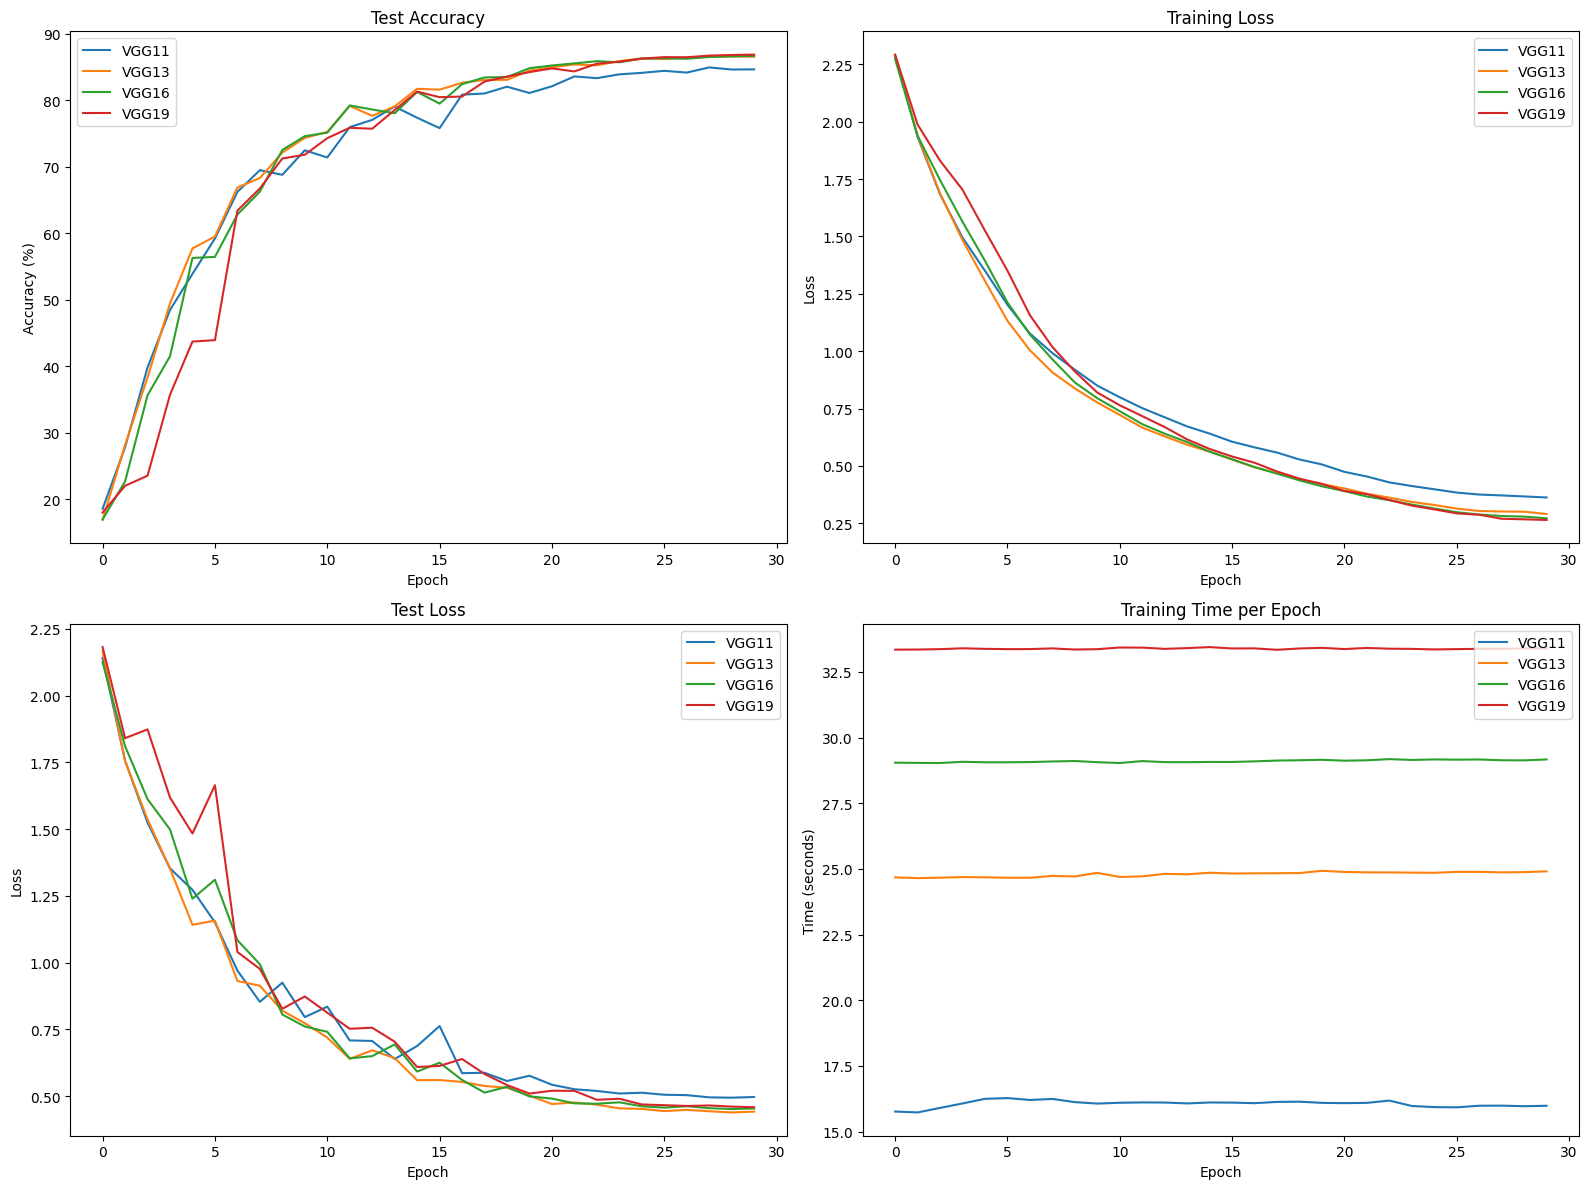


模型性能总结:
------------------------------------------------------------
模型名称       参数数量         最终准确率        总训练时间        每轮平均时间      
------------------------------------------------------------
VGG11      9,374,410    84.63       % 481.76      秒 16.06       秒
VGG13      9,559,306    86.54       % 743.90      秒 24.80       秒
VGG16      14,871,562   86.65       % 873.11      秒 29.10       秒
VGG19      20,183,818   86.85       % 1001.57     秒 33.39       秒
------------------------------------------------------------


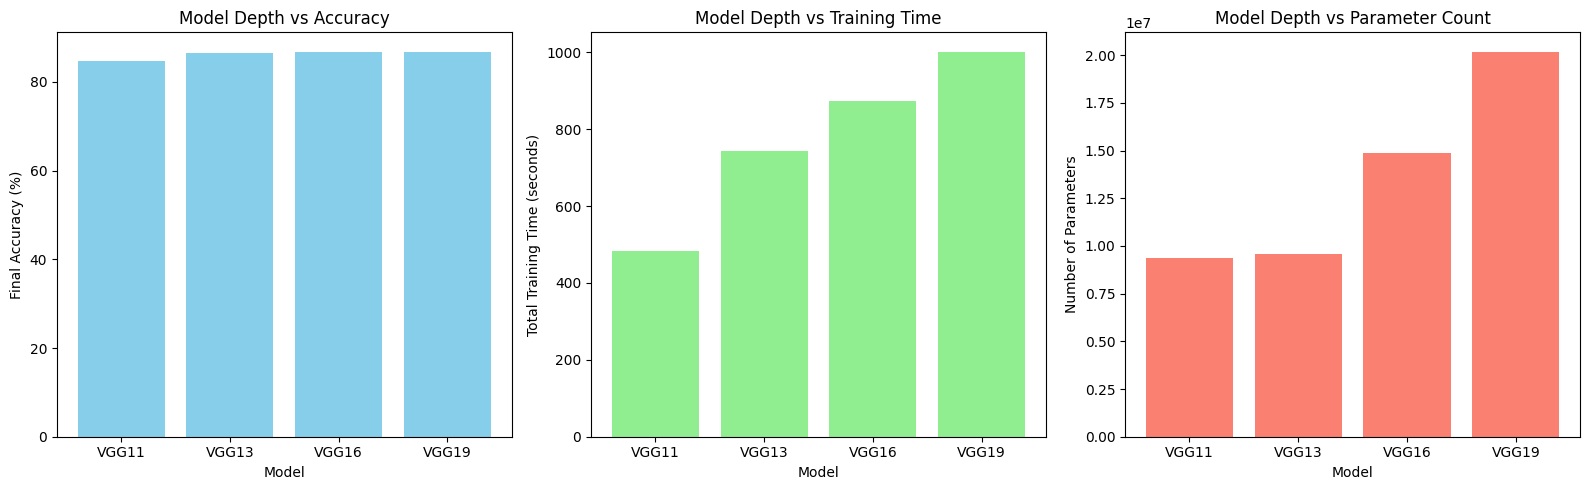

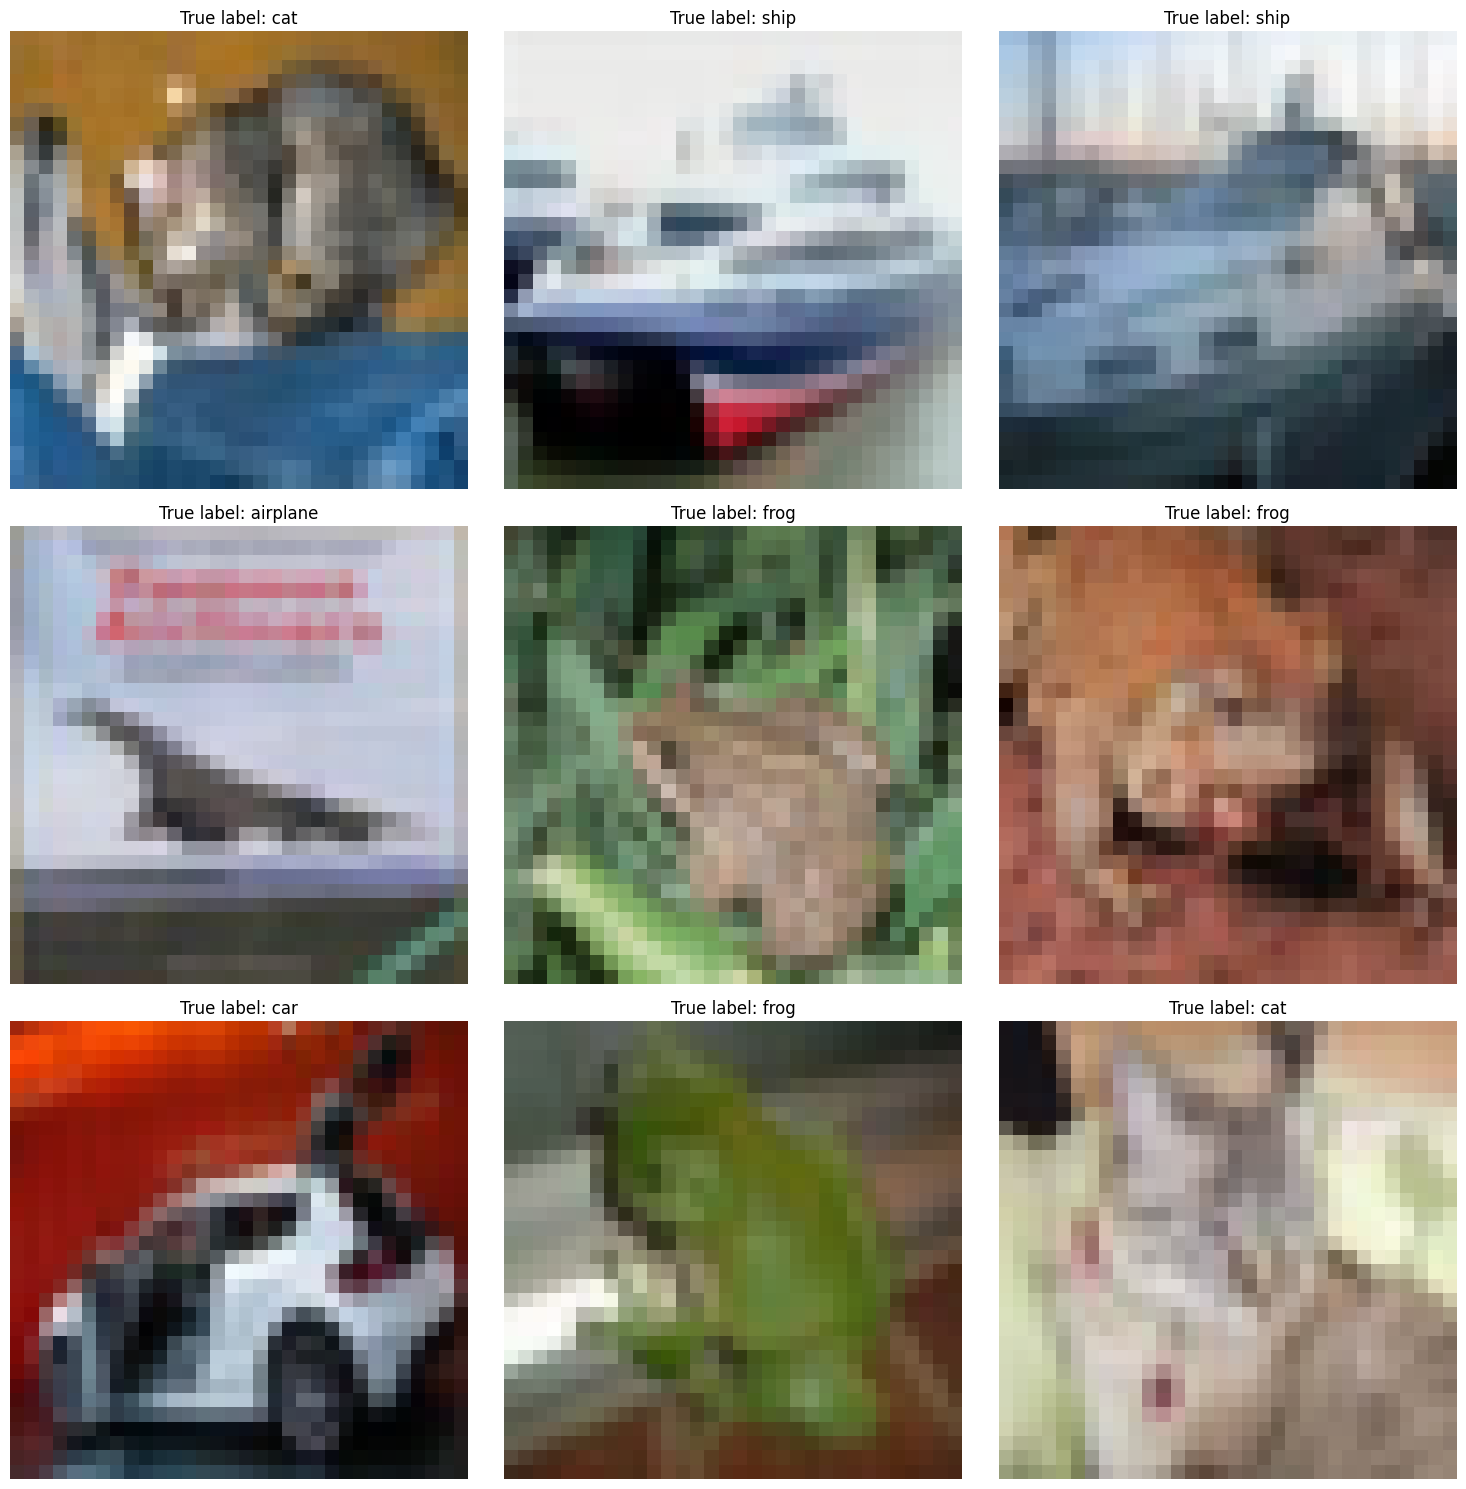

Sample 1 - True label: cat
  VGG11: cat ✓
  VGG13: cat ✓
  VGG16: cat ✓
  VGG19: cat ✓

Sample 2 - True label: ship
  VGG11: ship ✓
  VGG13: ship ✓
  VGG16: ship ✓
  VGG19: ship ✓

Sample 3 - True label: ship
  VGG11: ship ✓
  VGG13: ship ✓
  VGG16: ship ✓
  VGG19: ship ✓

Sample 4 - True label: airplane
  VGG11: ship ✗
  VGG13: airplane ✓
  VGG16: airplane ✓
  VGG19: airplane ✓

Sample 5 - True label: frog
  VGG11: frog ✓
  VGG13: frog ✓
  VGG16: frog ✓
  VGG19: frog ✓

Sample 6 - True label: frog
  VGG11: frog ✓
  VGG13: frog ✓
  VGG16: frog ✓
  VGG19: frog ✓

Sample 7 - True label: car
  VGG11: car ✓
  VGG13: car ✓
  VGG16: car ✓
  VGG19: car ✓

Sample 8 - True label: frog
  VGG11: frog ✓
  VGG13: frog ✓
  VGG16: frog ✓
  VGG19: frog ✓

Sample 9 - True label: cat
  VGG11: cat ✓
  VGG13: cat ✓
  VGG16: cat ✓
  VGG19: cat ✓



In [4]:

# 可视化不同模型的性能比较
plt.figure(figsize=(16, 12))

# 显示测试准确率
plt.subplot(2, 2, 1)
for model_name in models_to_compare:
    plt.plot(results[model_name]['test_accs'], label=model_name)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# 显示训练损失
plt.subplot(2, 2, 2)
for model_name in models_to_compare:
    plt.plot(results[model_name]['train_losses'], label=model_name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 显示测试损失
plt.subplot(2, 2, 3)
for model_name in models_to_compare:
    plt.plot(results[model_name]['test_losses'], label=model_name)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 显示每轮训练时间
plt.subplot(2, 2, 4)
for model_name in models_to_compare:
    plt.plot(results[model_name]['times'], label=model_name)
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

# 显示模型总结
print("\n模型性能总结:")
print("-" * 60)
print(f"{'模型名称':<10} {'参数数量':<12} {'最终准确率':<12} {'总训练时间':<12} {'每轮平均时间':<12}")
print("-" * 60)

for model_name in models_to_compare:
    model = VGG(model_name)
    param_count = sum(p.numel() for p in model.parameters())
    final_acc = results[model_name]['final_accuracy']
    total_time = results[model_name]['total_time']
    avg_time = total_time / epoch_count
    
    print(f"{model_name:<10} {param_count:<12,d} {final_acc:<12.2f}% {total_time:<12.2f}秒 {avg_time:<12.2f}秒")

print("-" * 60)

# 绘制模型深度与性能关系图
depths = [len([x for x in cfg[name] if x != 'M']) for name in models_to_compare]  # 计算每个模型的卷积层数量
final_accs = [results[name]['final_accuracy'] for name in models_to_compare]
total_times = [results[name]['total_time'] for name in models_to_compare]
param_counts = [sum(p.numel() for p in VGG(name).parameters()) for name in models_to_compare]

plt.figure(figsize=(16, 5))

# 模型深度vs准确率
plt.subplot(1, 3, 1)
plt.bar(models_to_compare, final_accs, color='skyblue')
plt.title('Model Depth vs Accuracy')
plt.xlabel('Model')
plt.ylabel('Final Accuracy (%)')

# 模型深度vs训练时间
plt.subplot(1, 3, 2)
plt.bar(models_to_compare, total_times, color='lightgreen')
plt.title('Model Depth vs Training Time')
plt.xlabel('Model')
plt.ylabel('Total Training Time (seconds)')

# 模型深度vs参数数量
plt.subplot(1, 3, 3)
plt.bar(models_to_compare, param_counts, color='salmon')
plt.title('Model Depth vs Parameter Count')
plt.xlabel('Model')
plt.ylabel('Number of Parameters')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

# 可视化特定样本在各个模型上的预测
def visualize_predictions():
    # 获取一批测试数据
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    
    # 选择9个样本
    plt.figure(figsize=(15, 15))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        # 显示图像并反归一化以获得更好的视觉效果
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        mean = np.array((0.4914, 0.4822, 0.4465))
        std = np.array((0.2023, 0.1994, 0.2010))
        img = img * std + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"True label: {classes[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # 比较不同模型的预测结果
    model_predictions = {}
    for model_name in models_to_compare:
        model = VGG(model_name)
        model.load_state_dict(torch.load(f'cifar10_{model_name.lower()}.pth'))
        model = model.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(images.to(device))
            _, predicted = outputs.max(1)
            model_predictions[model_name] = predicted.cpu().numpy()
    
    # 显示每个模型的预测结果
    for i in range(9):
        print(f"Sample {i+1} - True label: {classes[labels[i]]}")
        for model_name in models_to_compare:
            pred_label = model_predictions[model_name][i]
            correct = "✓" if pred_label == labels[i] else "✗"
            print(f"  {model_name}: {classes[pred_label]} {correct}")
        print()

# 执行预测可视化
visualize_predictions()